In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Baseline cGAN for single image

In [22]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.optim import lr_scheduler


def get_norm_layer(norm_type='instance'):
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'switchable':
        norm_layer = SwitchNorm2d
    elif norm_type == 'none':
        norm_layer = None
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer


def get_scheduler(optimizer, opt):
    if opt.lr_policy == 'lambda':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + opt.epoch_count - opt.niter) / float(opt.niter_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
    elif opt.lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    elif opt.lr_policy == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=opt.niter, eta_min=0)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler


# update learning rate (called once every epoch)
def update_learning_rate(scheduler, optimizer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print('learning rate = %.7f' % lr)


def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)


def init_net(net, init_type='normal', init_gain=0.02):
    init_weights(net, init_type, gain=init_gain)
    return net


# Defines the generator
def define_G(input_nc, output_nc, ngf, netG, norm='batch', use_dropout=False, init_type='normal', init_gain=0.02):
    """Create a generator

    Parameters:
        input_nc (int) -- the number of channels in input images
        output_nc (int) -- the number of channels in output images
        ngf (int) -- the number of filters in the last conv layer
        netG (str) -- the architecture's name: resnet_9blocks | resnet_6blocks | unet_256 | unet_128 | unet_64
        norm (str) -- the name of normalization layers used in the network: batch | instance | none
        use_dropout (bool) -- if use dropout layers.
        init_type (str)    -- the name of our initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Returns a generator

    Our current implementation provides two types of generators:
        U-Net: [unet_128] (for 128x128 input images) and [unet_256] (for 256x256 input images)
        The original U-Net paper: https://arxiv.org/abs/1505.04597

        Resnet-based generator: [resnet_6blocks] (with 6 Resnet blocks) and [resnet_9blocks] (with 9 Resnet blocks)
        Resnet-based generator consists of several Resnet blocks between a few downsampling/upsampling operations.
        We adapt Torch code from Justin Johnson's neural style transfer project (https://github.com/jcjohnson/fast-neural-style).


    The generator has been initialized by <init_net>. It uses RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netG == 'resnet_9blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9)
    elif netG == 'resnet_6blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=6)
    elif netG == 'unet_64':
        net = UnetGenerator(input_nc, output_nc, 6, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    elif netG == 'unet_128':
        net = UnetGenerator(input_nc, output_nc, 7, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    elif netG == 'unet_256':
        net = UnetGenerator(input_nc, output_nc, 8, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    else:
        raise NotImplementedError('Generator model name [%s] is not recognized' % netG)
    return init_net(net, init_type, init_gain)

# Defines the Discriminator
def define_D(input_nc, ndf, netD, n_layers_D=3, norm='batch', init_type='normal', init_gain=0.02):
    """Create a discriminator

    Parameters:
        input_nc (int)     -- the number of channels in input images
        ndf (int)          -- the number of filters in the first conv layer
        netD (str)         -- the architecture's name: basic | n_layers | pixel
        n_layers_D (int)   -- the number of conv layers in the discriminator; effective when netD=='n_layers'
        norm (str)         -- the type of normalization layers used in the network.
        init_type (str)    -- the name of the initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Returns a discriminator

    Our current implementation provides three types of discriminators:
        [basic]: 'PatchGAN' classifier described in the original pix2pix paper.
        It can classify whether 70×70 overlapping patches are real or fake.
        Such a patch-level discriminator architecture has fewer parameters
        than a full-image discriminator and can work on arbitrarily-sized images
        in a fully convolutional fashion.

        [n_layers]: With this mode, you can specify the number of conv layers in the discriminator
        with the parameter <n_layers_D> (default=3 as used in [basic] (PatchGAN).)

        [pixel]: 1x1 PixelGAN discriminator can classify whether a pixel is real or not.
        It encourages greater color diversity but has no effect on spatial statistics.

    The discriminator has been initialized by <init_net>. It uses Leakly RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netD == 'basic':  # default PatchGAN classifier
        net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer)
    elif netD == 'n_layers':  # more options
        net = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer)
    elif netD == 'pixel':     # classify if each pixel is real or fake
        net = PixelDiscriminator(input_nc, ndf, norm_layer=norm_layer)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' % netD)
    return init_net(net, init_type, init_gain)

class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer

        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""

        return self.model(input)

class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.

        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

class PixelDiscriminator(nn.Module):
    """Defines a 1x1 PatchGAN discriminator (pixelGAN)"""

    def __init__(self, input_nc, ndf=64, norm_layer=nn.BatchNorm2d):
        """Construct a 1x1 PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        """
        super(PixelDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.net = [
            nn.Conv2d(input_nc, ndf, kernel_size=1, stride=1, padding=0),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=1, stride=1, padding=0, bias=use_bias),
            norm_layer(ndf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 2, 1, kernel_size=1, stride=1, padding=0, bias=use_bias)]

        self.net = nn.Sequential(*self.net)

    def forward(self, input):
        """Standard forward."""
        return self.net(input)


class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        if use_lsgan:
            self.loss = nn.MSELoss()
        else:
            self.loss = nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(input)

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)


initialize network with normal


<ipython-input-23-7e24e31e9fa1>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda' if torch.cuda

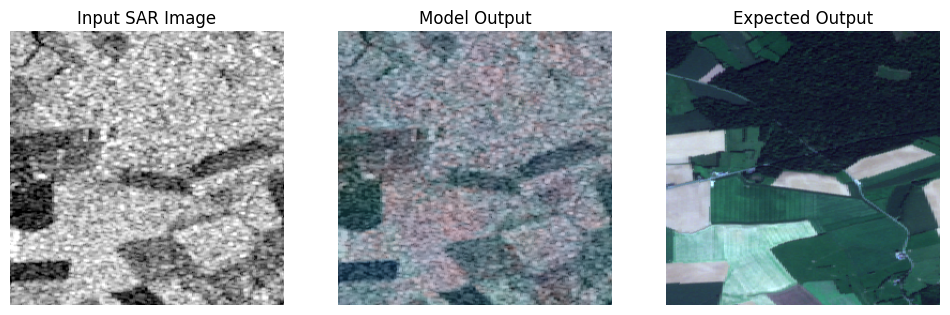

PSNR = 8.82, SSIM = 0.0877


In [23]:
import torch
from torchvision import transforms
from PIL import Image
import os
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import numpy as np

# Define model parameters
input_nc = 1  # Number of input channels (grayscale SAR images)
output_nc = 3  # Number of output channels (RGB colorized output)
ngf = 64  # Number of filters in the last conv layer
netG = 'unet_256'  # Use the U-Net architecture
norm = 'batch'  # Normalization type
init_type = 'normal'  # Initialization type
init_gain = 0.02  # Initialization gain
model_path = '/content/drive/MyDrive/SAR_Image_Colorization/Baseline_cGAN/cgan4colsar_generator_saved_model.pth'  # Path to the trained model weights

# Load the model
model = define_G(input_nc, output_nc, ngf, netG, norm=norm, init_type=init_type, init_gain=init_gain)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model.eval()  # Set the model to evaluation mode

# Define image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Directories
input_image_path = '/content/drive/MyDrive/SAR_Image_Colorization/sample_images/sar_images/sample_input_1.png'  # Path to the input SAR image
expected_image_path = '/content/drive/MyDrive/SAR_Image_Colorization/sample_images/expected_images/expected_output_1.png'  # Path to the expected colorized image
output_image_path = '/content/drive/MyDrive/SAR_Image_Colorization/sample_images/output_cGAN/output_1.png' # Path to save the generated colorized image

# Create output folder if it doesn't exist
os.makedirs(os.path.dirname(output_image_path), exist_ok=True)

# Load and preprocess the input image
input_image = Image.open(input_image_path).convert('L')
input_tensor = transform(input_image).unsqueeze(0).to(next(model.parameters()).device)

# Run the model
with torch.no_grad():
    output_tensor = model(input_tensor)

# Convert model output to image
output_image = output_tensor.squeeze().cpu()
output_image = transforms.ToPILImage()(output_image)

# Save the generated colorized image
output_image.save(output_image_path)

# Load expected output image for comparison
expected_image = Image.open(expected_image_path).convert('RGB').resize((256, 256))

# Calculate PSNR and SSIM
output_np = np.array(output_image)
expected_np = np.array(expected_image)
psnr_value = psnr(expected_np, output_np)
ssim_value = ssim(expected_np, output_np, win_size=5, channel_axis=-1)

# Display images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Input SAR Image")
plt.imshow(input_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Model Output")
plt.imshow(output_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Expected Output")
plt.imshow(expected_image)
plt.axis('off')

plt.show()

# Print PSNR and SSIM scores
print(f"PSNR = {psnr_value:.2f}, SSIM = {ssim_value:.4f}")
